In [15]:
!pip install ultralytics tensorflow opencv-python pillow faiss-cpu sentence-transformers matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [16]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import transformers
import os
import warnings
warnings.filterwarnings("ignore")

## Load image dataset for computer vision

In [17]:
DIR = "../data/IMG_VALID" # Directory containing images

# Load images paths using glob
def load_image_paths(img_dir=DIR, num_images=None):
    image_paths = glob.glob(os.path.join(img_dir, "*.jpg"))
    print(f"Total Images: {len(image_paths)}")
    return image_paths[:num_images]

load_image_paths()

Total Images: 947


['../data/IMG_VALID/111_20220211T041351392Z_s00.mp4_2400.jpg',
 '../data/IMG_VALID/10_20220315T010303302Z_s00.mp4_44600.jpg',
 '../data/IMG_VALID/111_20220422T014816656Z_s00.mp4_14300.jpg',
 '../data/IMG_VALID/104_20220321T021706325Z_s00.mp4_2000.jpg',
 '../data/IMG_VALID/12_20220527T120309238Z_s00.mp4_1100.jpg',
 '../data/IMG_VALID/119_20220322T120533980Z_s00.mp4_36300.jpg',
 '../data/IMG_VALID/114_20220616T122504219Z_s00.mp4___750.jpg',
 '../data/IMG_VALID/104_20220506T124337874Z_s00.mp4_122600.jpg',
 '../data/IMG_VALID/122_20220425T120526983Z_s00.mp4_91000.jpg',
 '../data/IMG_VALID/13_20210802T102721443Z_s00frame632599236716.jpg',
 '../data/IMG_VALID/122_20220323T010604729Z_s00.mp4_62500.jpg',
 '../data/IMG_VALID/101_20220321T021439555Z_s00.mp4_900.jpg',
 '../data/IMG_VALID/123_20220503T061702133Z_s00.mp4___450.jpg',
 '../data/IMG_VALID/122_20220503T061600595Z_s00.mp4___500.jpg',
 '../data/IMG_VALID/120_20220322T011638792Z_s00.mp4_11900.jpg',
 '../data/IMG_VALID/131_20220504T1203192

In [18]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Visualization + YOLO Label Overlay

In [19]:
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


def visualize_yolo_grid(image_paths, labels_dir, cols=4, figsize=(16, 10)):

    total_images = len(image_paths)
    rows = math.ceil(total_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Consistency in figure size
    axes = axes.flatten()

    for idx, img_path in enumerate(image_paths):

        # ======================
        # LOAD IMAGE
        # ======================

        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        ax = axes[idx]
        ax.imshow(img)
        ax.axis("off")

        # ======================
        # LOAD LABEL
        # ======================

        label_file = os.path.join(
            labels_dir,
            os.path.basename(img_path).replace(".jpg", ".txt")
        )

        if os.path.exists(label_file):
            with open(label_file) as f:
                for line in f:
                    class_id, x_center, y_center, box_weight, box_height = map(float, line.split())

                    # Convert YOLO format to pixel values
                    x_center *= w
                    y_center *= h
                    box_weight *= w
                    box_height *= h

                    x_min = x_center - box_weight / 2
                    y_min = y_center - box_height / 2

                    rect = plt.Rectangle(
                        (x_min, y_min),
                        box_weight,
                        box_height,
                        fill=False,
                        linewidth=2
                    )
                    ax.add_patch(rect)

                    # Lable text
                    ax.text(
                        x_min,
                        y_min - 5,
                        f"ID: {int(class_id)}",
                        fontsize=10,
                        color="white",
                        bbox=dict(facecolor='black', alpha=0.6)
                    )

        # ======================
        # TITLE (FILENAME)
        # ======================

        filename = os.path.basename(img_path)
        ax.set_title(filename[:25], fontsize=12)

    # ======================
    # HIDE EMPTY SUBPLOTS
    # ======================

    for i in range(total_images, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

Total Images: 947


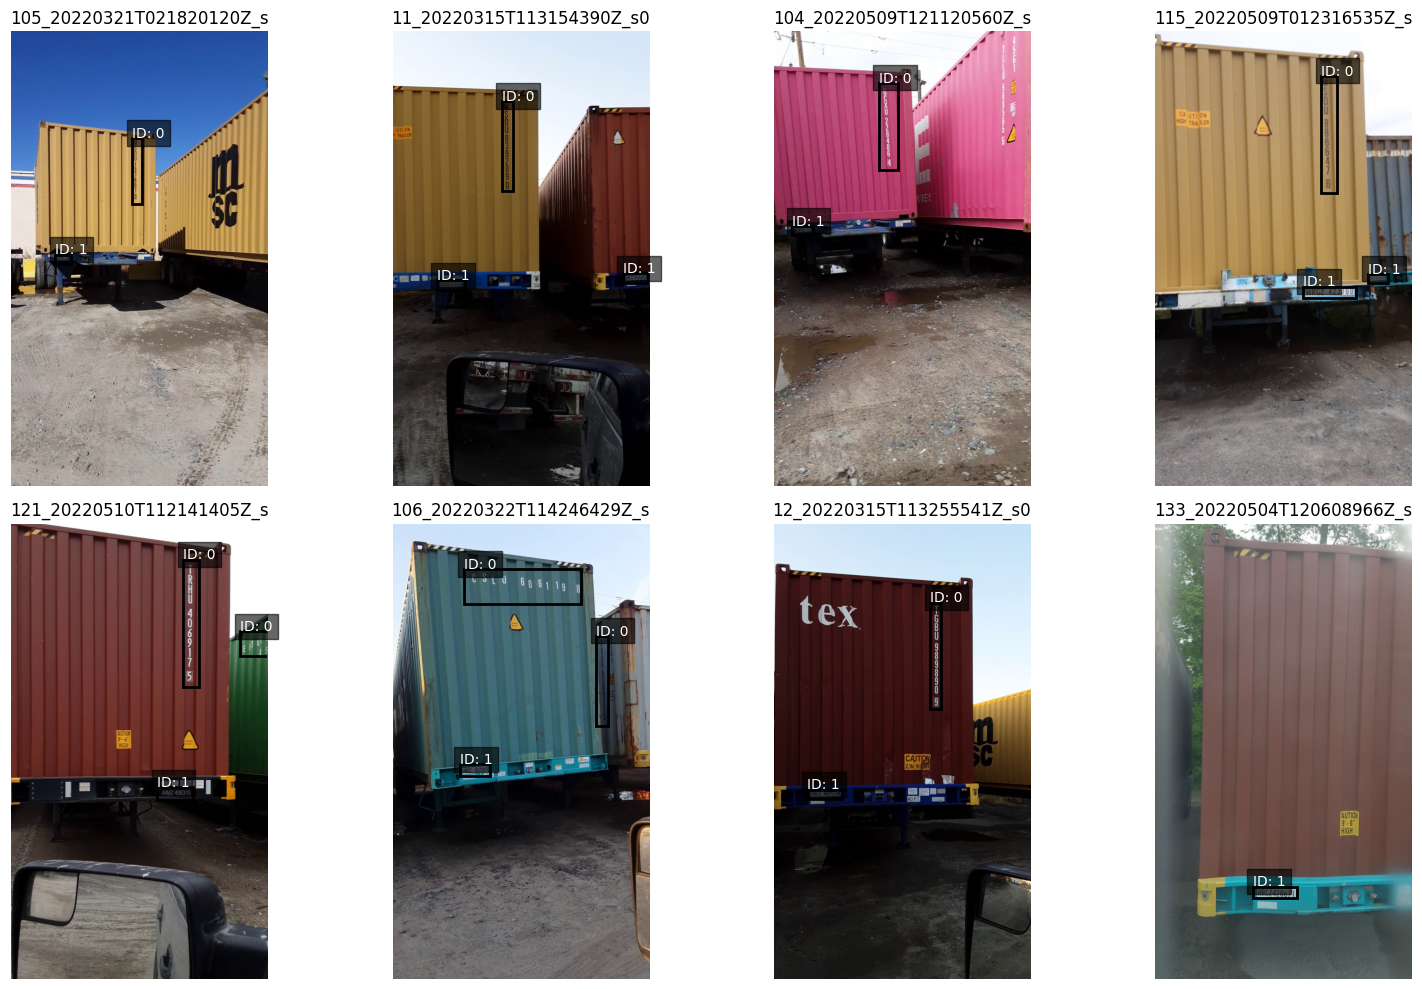

In [20]:
image_path = load_image_paths()[-8:]
visualize_yolo_grid(image_paths=image_path, labels_dir=DIR, cols=4)

# Import & Config

In [21]:
import os
import random
import shutil
from glob import glob

In [22]:
DATA_RAW = "../data/IMG_VALID"
DATASET = "dataset"

IMG_SIZE = 640
BATCH = 8
EPOCHS = 80

# Prepare Folder Structure

In [23]:
paths = [
    "images/train",
    "images/val",
    "labels/train",
    "labels/val"
]

for p in paths:
    dir_path = os.path.join(DATASET, p)
    os.makedirs(dir_path, exist_ok=True)

# Auto Split Dataset (80/20)

In [25]:
# Check if dataset already exists (both images and labels)
train_img_dir = os.path.join(DATASET, "images/train")
train_lbl_dir = os.path.join(DATASET, "labels/train")

existing_imgs = len(glob(f"{train_img_dir}/*.jpg")) if os.path.exists(train_img_dir) else 0
existing_lbls = len(glob(f"{train_lbl_dir}/*.txt")) if os.path.exists(train_lbl_dir) else 0

if existing_imgs > 0 or existing_lbls > 0:
    print(f"⚠️ Dataset already exists (Images: {existing_imgs}, Labels: {existing_lbls}). Skipping...")
else:
    images = glob(f"{DATA_RAW}/*.jpg")
    print(f"📦 Total Images: {len(images)}")
    
    random.shuffle(images)
    split_idx = int(0.8 * len(images))
    
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]
    
    # Copy function
    def copy_data(imgs, img_dst, label_dst):
        for img in imgs:
            name = os.path.basename(img)
            label = img.replace(".jpg", ".txt")
            
            shutil.copy(img, os.path.join(img_dst, name))
            if os.path.exists(label):
                shutil.copy(label, os.path.join(label_dst, os.path.basename(label)))
    
    # Copy data
    copy_data(train_imgs, os.path.join(DATASET, "images/train"), os.path.join(DATASET, "labels/train"))
    copy_data(val_imgs, os.path.join(DATASET, "images/val"), os.path.join(DATASET, "labels/val"))
    
    print(f"✅ Data copied! Train: {len(train_imgs)}, Val: {len(val_imgs)}")

⚠️ Dataset already exists (Images: 757, Labels: 757). Skipping...


## Create YOLO Config File

In [26]:
yaml_content = """
path: dataset
train: images/train
val: images/val

nc: 4

names:
  0: dent
  1: rust
  2: broken_door
  3: leak
"""

with open("container.yaml", "w") as f:
    f.write(yaml_content)

print("✅ YOLO config file created: container.yaml")

✅ YOLO config file created: container.yaml


# YOLOv8 Training (Transfer Learning)

In [28]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Load pre-trained YOLOv8n model

model.train(
    data="container.yaml",
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    lr0=0.001,
    freeze=10,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
)

Ultralytics 8.4.7 🚀 Python-3.11.9 torch-2.9.1 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=container.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x109c816d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([0.        , 0.001001  , 0.002002  , 0.003003  , 0.004004  ,
       0.00500501, 0.00600601, 0.00700701, 0.00800801, 0.00900901,
       0.01001001, 0.01101101, 0.01201201, 0.01301301, 0.01401401,
       0.01501502, 0.01601602, 0.01701702, 0.01801802, 0.01901902,
       0.02002002, 0.02102102, 0.02202202, 0.02302302, 0.02402402,
       0.02502503, 0.02602603, 0.02702703, 0.02802803, 0.02902903,
       0.03003003, 0.03103103, 0.03203203, 0.03303303, 0.03403403,
       0.03503504, 0.03603604, 0.03703704, 0.03803804, 0.03903904,
       0.04004004, 0.04104104, 0.04204204, 0.04304304, 0.04404404,
       0.04504505, 0.04604605, 0.04704705, 0.04804805, 

In [29]:
metrics = model.val()

print("mAP50-95:", metrics.box.map)
print("Recall:", metrics.box.recall)
print("Precision:", metrics.box.precision)

Ultralytics 8.4.7 🚀 Python-3.11.9 torch-2.9.1 CPU (Apple M4)
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1144.3±228.2 MB/s, size: 457.8 KB)
Model summary (fused): 73 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1144.3±228.2 MB/s, size: 457.8 KB)
val: Scanning /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/labels/val.cache... 190 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 190/190 199.2Mit/s 0.0s
val: Scanning /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/dataset/labels/val.cache... 190 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 190/190 199.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2.1s/it 25.0s2.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 12/12 2

AttributeError: 'Metric' object has no attribute 'recall'. See valid attributes below.
Class for computing evaluation metrics for Ultralytics YOLO models.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50: AP at IoU threshold of 0.5 for all classes.
        ap: AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mp: Mean precision of all classes.
        mr: Mean recall of all classes.
        map50: Mean AP at IoU threshold of 0.5 for all classes.
        map75: Mean AP at IoU threshold of 0.75 for all classes.
        map: Mean AP at IoU thresholds from 0.5 to 0.95 for all classes.
        mean_results: Mean of results, returns mp, mr, map50, map.
        class_result: Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps: mAP of each class.
        fitness: Model fitness as a weighted combination of metrics.
        update: Update metric attributes with new evaluation results.
        curves: Provides a list of curves for accessing specific metrics like precision, recall, F1, etc.
        curves_results: Provide a list of results for accessing specific metrics like precision, recall, F1, etc.
    

# Export YOLO → TensorFlow

In [30]:
model.export(format="saved_model")

Ultralytics 8.4.7 🚀 Python-3.11.9 torch-2.9.1 CPU (Apple M4)

PyTorch: starting from '/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)

PyTorch: starting from '/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.9 MB)
requirements: Ultralytics requirements ['tf_keras<=2.19.0', 'sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0,<1.4.0', 'onnx>=1.12.0,<2.0.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
requirements: Ultralytics requirements ['tf_keras<=2.19.0', 'sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0,<1.4.0', 'onnx>=1.12.0,<2.0.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.

I0000 00:00:1769500878.339514  348115 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1769500878.339894  348115 single_machine.cc:376] Starting new session
W0000 00:00:1769500878.653529  348115 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1769500878.653545  348115 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1769500878.973735  348115 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1769500878.973805  348115 single_machine.cc:376] Starting new session
W0000 00:00:1769500878.653529  348115 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1769500878.653545  348115 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1769500878.973735  348115 devices.cc:76] Number of

TensorFlow SavedModel: export success ✅ 224.6s, saved as '/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best_saved_model' (29.3 MB)

Export complete (224.9s)
Results saved to /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights
Predict:         yolo predict task=detect model=/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best_saved_model imgsz=640 
Validate:        yolo val task=detect model=/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best_saved_model imgsz=640 data=container.yaml  
Visualize:       https://netron.app

Export complete (224.9s)
Results saved to /Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights
Predict:         yolo predict task=detect model=/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best_saved_model imgsz=640 
Validate:        yolo val task=detect

W0000 00:00:1769500879.291638  348115 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1769500879.291648  348115 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


'/Users/miftahhadiyannoor/Documents/logistics-rag/notebooks/runs/detect/train/weights/best_saved_model'

In [ ]:
# Load the exported TensorFlow model
import tensorflow as tf

TF_MODEL_PATH = "runs/detect/train/weights/best_saved_model"
tf_model = tf.saved_model.load(TF_MODEL_PATH)

# Check model signature
print("Model Signatures:", tf_model.signatures.keys())

Model Signatures: KeysView(_SignatureMap({'serving_default': <ConcreteFunction (*, images: TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')) -> Dict[['output_0', TensorSpec(shape=(1, 8, 8400), dtype=tf.float32, name='output_0')]] at 0x3278EFD10>}))
